# Computing the polarization resistance for synthetic data

In this example, we are going to use the standard 1xZARC model to illustrate how the impedance can be recovered with Gaussian processes using either the real part, the imaginary part, or both parts of the experimental impedance. Then, we illustrate how to evaluate the polarization resistance as a stochastic Gaussian variable. More details can be found in: B. Py, A. Maradesa, and F. Ciucci. "Gaussian Processes for the Analysis of Electrochemical Impedance Spectroscopy Data: Prediction, Filtering, and Active Learning.", preprint (2022).

In [1]:
# import the libraries needed
import importlib
import GP_hilbert as gpf
importlib.reload(gpf)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# plot standards
plt.rc('font', family='serif', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

## 1) Define the synthetic impedance experiment $Z_{\rm exp}(\omega)$

### 1.1) Define frequency range

In [3]:
N_freqs = 81
freq_vec = np.logspace(-2., 6., num=N_freqs, endpoint=True)
omega_vec = 2.*np.pi*freq_vec

### 1.2) Define the circuit parameters

In [4]:
R_ct = 50. # Ohm
R_inf = 10. # Ohm
phi = 0.8 # dimensionless
tau_0 = 0.1 # s
L_0 = 0 # H

### 1.3) Generate exact impedance $Z_{\rm exact}(\omega)$ 

In [5]:
T = tau_0**phi/R_ct
Z_exact = R_inf +  1j*(2*np.pi*freq_vec)*L_0 + 1./(1./R_ct+T*(1j*2.*np.pi*freq_vec)**phi)

### 1.4) Generate stochastic experiment with $Z_{\rm exp}(\omega) = Z_{\rm exact}(\omega)+ \sigma_n (\varepsilon_{\rm re} + i\varepsilon_{\rm im})$ where $\varepsilon_{\rm re}$ and $\varepsilon_{\rm im}$ are independent and identically distributed normals centered with 0 mean and standard deviation equal to 1

In [6]:
rng = np.random.seed(2421975) # seed the random number generator
sigma_n_exp = 0.3
Z_exp = Z_exact + (sigma_n_exp)*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

### 1.5) Draw the Nyquist plot

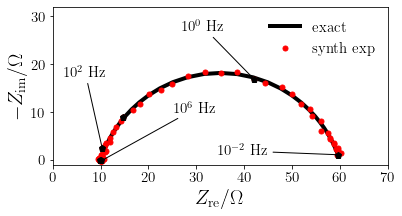

In [7]:
fig, ax = plt.subplots()
plt.plot(Z_exact.real, -Z_exact.imag, linewidth=4, color='black', label='exact')
plt.plot(Z_exp.real, -Z_exp.imag, 'o', markersize=5, color='red', label='synth exp')
plt.plot(np.real(Z_exp[0:70:20]), -np.imag(Z_exp[0:70:20]), 'p', markersize=7, color='black')
plt.plot(np.real(Z_exp[30]), -np.imag(Z_exp[30]), 'p', markersize=7, color='black')
plt.plot(np.real(Z_exp[77]), -np.imag(Z_exp[77]), 'p', markersize=7, color='black')

plt.annotate(r'$10^{-2}$ Hz', xy=(np.real(Z_exp[0]), -np.imag(Z_exp[0])),
             xytext=(np.real(Z_exp[0])-25, -np.imag(Z_exp[0])),
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{0}$ Hz', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])),
             xytext=(np.real(Z_exp[20])-15, 10-np.imag(Z_exp[20])),
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{2}$ Hz', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])),
             xytext=(np.real(Z_exp[40])-8, 15-np.imag(Z_exp[40])),
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))
plt.annotate(r'$10^{6}$ Hz', xy=(np.real(Z_exp[80]), -np.imag(Z_exp[80])),
             xytext=(np.real(Z_exp[80])+15, 10-np.imag(Z_exp[80])),
             arrowprops=dict(arrowstyle="-", connectionstyle="arc"))

plt.legend(frameon=False, fontsize=15, loc='upper right')
plt.axis('scaled')

plt.xlim(0, 70)
plt.ylim(-1, 32)
plt.xticks(range(0, 80, 10))
plt.yticks(range(0, 40, 10))
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

## 2) Set the kernel options 

In [8]:
ker_opts = {
    'sigma_DRT': 1.,
    'sigma_SB': 1.,
    'ell': 1.,
    'tau_max': 10,
    'DRT': True,
    'SB': True,
    'SB_ker_type': 'IQ',
}

# these values are nominal

## 3) Fit imaginary part of the data

### 3.1) Initialize the hyperparameters

In [9]:
sigma_n = 0.75
sigma_DRT = 11
sigma_SB = 1E-7
ell = 3
sigma_L = 5E-4

### 3.2) Maximize the experimental evidence, i.e., the negative marginal log-likelihood (NMML)

In [10]:
theta_0 = np.array([sigma_n, sigma_DRT, sigma_SB, ell, sigma_L])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], gpf.NMLL_fct(theta, Z_exp.imag, omega_vec, ker_opts, 'im')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})
#res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
                #callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta_im = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_L = theta_im

2.8806E-01, 2.9187E+01, -1.6632E-05, 3.0000E+00, -1.604260E-08; evidence = -2.86500209E+01
2.8006E-01, 2.9257E+01, 1.5374E-09, 5.6176E+00, 1.420816E-12; evidence = -2.88485918E+01
2.7954E-01, 2.9254E+01, -1.6214E-09, 8.2352E+00, 1.420816E-12; evidence = -2.88488289E+01
2.7954E-01, 2.9254E+01, -1.6099E-09, 1.0853E+01, 1.420816E-12; evidence = -2.88488289E+01
Optimization terminated successfully.
         Current function value: -28.848829
         Iterations: 4
         Function evaluations: 499


In [11]:
# update the values of the kernels as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

### 3.3) Check if the results are reasonable

### 3.3.1) Check $L_0$

We predict the value $\bar{L_0}$ of $L_{0}$ as

$$
\bar{L_0} = \frac {\boldsymbol \omega^\top (\mathbf K_{\rm im} + \sigma_{n}^{2} \mathbf{I})^{-1} \mathbf Z_{\rm exp,im}(\boldsymbol \omega)} {\sigma_{L}^{-2} + \boldsymbol \omega^\top (\mathbf K_{\rm im} + \sigma_{n}^{2} \mathbf{I})^{-1} \boldsymbol \omega} 
$$

See for more details Liu, Jiapeng, and Francesco Ciucci. "The Gaussian process distribution of relaxation times: A machine learning tool for the analysis and prediction of electrochemical impedance spectroscopy data." Electrochimica Acta 331 (2020): 135316.

In [12]:
K_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_im + Sigma + (sigma_L**2)*np.outer(omega_vec, omega_vec)
K_full_reg = K_im + Sigma

# Cholesky-decompose K_full
if not gpf.is_PD(K_full_reg):
    K_full_reg = gpf.nearest_PD(K_full_reg)

# inverse of K_im
L = np.linalg.cholesky(K_full_reg)
inv_L = np.linalg.inv(L)
inv_K_full_reg = np.dot(inv_L.T, inv_L)

num_L_0 = omega_vec@(inv_K_full_reg@Z_exp.imag)
den_L_0 = (sigma_L**-2) + omega_vec@(inv_K_full_reg@omega_vec)
L_0_est = num_L_0/den_L_0

print('L_0_est = %.6E F vs. L_0 = %.6E F'%(L_0_est, L_0))

L_0_est = 6.618300E-18 F vs. L_0 = 0.000000E+00 F


### 3.3.2) Check the fit of $\Im(Z_{\rm exp})$ against the GP

### 3.3.2.1) Run the GP regression

In [13]:
# Cholesky-decompose K_full
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec) #np.logspace(-4., 4., num=N_star_freqs, endpoint=True)
omega_star_vec = 2.*np.pi*freq_star_vec

mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)

for index, omega_star in enumerate(omega_star_vec):
    
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    k_star_star = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 'im').flatten() + (sigma_L**2)*omega_star_np**2
    k_star = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im').flatten() + (sigma_L**2)*omega_vec*omega_star_np
    
    mu_star_vec[index] = k_star@(inv_K_full@Z_exp.imag)
    sigma_star_vec[index] = np.sqrt(k_star_star - k_star@(inv_K_full@k_star))

### 3.3.2.2) Plot the outcome of the GP regression

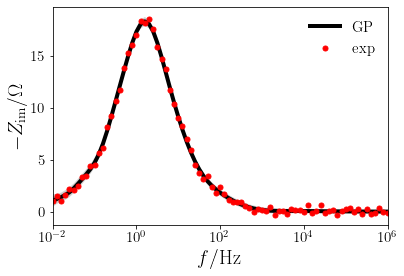

In [14]:
plt.fill_between(freq_star_vec, -mu_star_vec-3*sigma_star_vec, -mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, -mu_star_vec-2*sigma_star_vec, -mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, -mu_star_vec-sigma_star_vec, -mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, -mu_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  -Z_exp.imag, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

## 4) Fit real part of the data

### 4.1) Initialize the hyperparameters

In [15]:
sigma_n = 0.75
sigma_DRT = 11
sigma_SB = 1E-7
ell = 3
sigma_R = 5E-4

### 4.2) Maximize the NMLL

In [16]:
theta_0 = np.array([sigma_n, sigma_DRT, sigma_SB, ell, sigma_R])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], gpf.NMLL_fct(theta, Z_exp.real, omega_vec, ker_opts, 're')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp.real, omega_vec, ker_opts, 're'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})
#res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
               #callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta_re = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_R = theta_re

9.4250E+00, 8.6589E+01, 3.2473E-08, 5.6176E+00, 9.962484E+00; evidence = 1.97532240E+02
-2.9718E-01, -1.8546E+01, -1.3434E-08, 5.3016E+00, -8.297727E+00; evidence = -1.68747120E+01
-2.9486E-01, -2.6504E+01, -1.3434E-08, 7.9199E+00, -1.000312E+01; evidence = -1.91102510E+01
-2.9486E-01, -2.6506E+01, -1.7373E-07, 7.9205E+00, -1.000451E+01; evidence = -1.91102511E+01
Optimization terminated successfully.
         Current function value: -19.110251
         Iterations: 4
         Function evaluations: 494


In [17]:
# update the values of the kernel
# as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

### 4.3) Check if the results are reasonable

### 4.3.1) Check $R_\infty$

We predict the value $\bar{R_\infty}$ of $R_\infty$ as

$$
\bar{R_\infty} = \frac {\boldsymbol 1^\top (\mathbf K_{\rm re} + \sigma_{n}^{2} \mathbf{I})^{-1} \mathbf Z_{\rm exp,re}(\boldsymbol \omega)} {\sigma_{\rm R}^{-2} + \boldsymbol 1^\top (\mathbf K_{\rm re} + \sigma_{n}^{2} \mathbf{I})^{-1} \boldsymbol 1} 
$$

where $\boldsymbol 1$ is the column vector of size $N_{freqs}$ whose components are all equal to 1 (see C. E. Rasmussen and C. K. I. Williams, Gaussian Processes for Machine Learning (The MIT Press, Cambridge) (2005) for additional details).

In [18]:
K_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're')
Sigma = (sigma_n**2)*np.eye(N_freqs)
K_full = K_re + Sigma + (sigma_R**2)*np.ones_like(Sigma)
K_full_reg = K_re + Sigma

# Cholesky-decompose K_full
if not gpf.is_PD(K_full_reg):
    K_full_reg = gpf.nearest_PD(K_full_reg)

# inverse of K_re
L = np.linalg.cholesky(K_full_reg)
inv_L = np.linalg.inv(L)
inv_K_full_reg = np.dot(inv_L.T, inv_L)

num_R_inf = np.ones(N_freqs)@(inv_K_full_reg@Z_exp.real)
den_R_inf = (sigma_R**-2) + np.ones(N_freqs)@(inv_K_full_reg@np.ones(N_freqs))
R_inf_est = num_R_inf/den_R_inf

print('R_inf_est = %.6E Ohm vs. R_inf = %.6E Ohm'%(R_inf_est, R_inf))

R_inf_est = 1.000426E+01 Ohm vs. R_inf = 1.000000E+01 Ohm


### 4.3.2) Check the fit of $\Re(Z_{\rm exp})$ against the GP

### 4.3.2.1) Run the GP regression

In [19]:
# Cholesky-decompose K_full
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec) #np.logspace(-4., 4., num=N_star_freqs, endpoint=True)
omega_star_vec = 2.*np.pi*freq_star_vec

mu_star_vec = np.zeros_like(omega_star_vec)
sigma_star_vec = np.zeros_like(omega_star_vec)

for index, omega_star in enumerate(omega_star_vec):
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    
    k_star_star = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 're').flatten() + (sigma_R**2)
    k_star = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're').flatten() + (sigma_R**2)*np.ones(N_freqs)

    mu_star_vec[index] = k_star@(inv_K_full@Z_exp.real)
    sigma_star_vec[index] = np.sqrt(k_star_star - k_star@(inv_K_full@k_star))

### 4.3.2.2) Plot the outcome of the GP regression

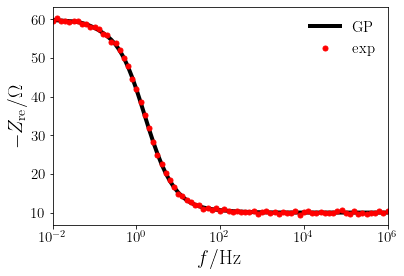

In [20]:
plt.fill_between(freq_star_vec, mu_star_vec-3*sigma_star_vec, mu_star_vec+3*sigma_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, mu_star_vec-2*sigma_star_vec, mu_star_vec+2*sigma_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, mu_star_vec-sigma_star_vec, mu_star_vec+sigma_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, mu_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  Z_exp.real, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm re}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

## 5) Bundle things together

In [21]:
Z_exp_all = np.zeros(2*N_freqs)
Z_exp_all[:N_freqs] = Z_exp.real
Z_exp_all[N_freqs:] = Z_exp.imag

### 5.1) Initialize the hyperparameters

In [22]:
sigma_n, sigma_DRT, sigma_SB, ell = 0.5*(abs(theta_re[:4])+abs(theta_im[:4]))
sigma_R = abs(theta_re[-1])
sigma_L = abs(theta_im[-1])

In [37]:
theta_0 = [sigma_n, sigma_DRT, sigma_SB, ell, sigma_R, sigma_L]
seq_theta = np.copy(theta_0)

def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('%.4E, %.4E, %.4E, %.4E %.4E, %.6E; evidence = %.8E'%(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], gpf.NMLL_fct(theta, Z_exp_all, omega_vec, ker_opts, 'all')))
    
res = minimize(gpf.NMLL_fct, theta_0, args=(Z_exp_all, omega_vec, ker_opts, 'all'), method='Powell', \
               callback=print_results, options={'disp': True, 'xtol': 1E-6, 'ftol': 1E-6})
#res = minimize(gpf.NMLL_fct, res.x, args=(Z_exp.imag, omega_vec, ker_opts, 'im'), method='Nelder-Mead', \
               #callback=print_results, options={'disp': True, 'xatol': 1E-6, 'fatol': 1E-6})

theta = res.x
sigma_n, sigma_DRT, sigma_SB, ell, sigma_R, sigma_L = theta

2.8491E-01, 2.6651E+01, -2.6169E-07, 8.7230E+00 9.9934E+00, 1.420816E-12; evidence = -7.80203785E+01
Optimization terminated successfully.
         Current function value: -78.020379
         Iterations: 1
         Function evaluations: 195


In [38]:
# update the values of the kernel
# as the gpf functions simply copy ker_opts
ker_opts['sigma_SB'] = sigma_SB
ker_opts['ell'] = ell
ker_opts['sigma_DRT'] = sigma_DRT

### 5.2) Check if the results are reasonable

Compute the block matrix according to Equation (6c) from the main manuscript.

In [39]:
K_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're')
K_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im')
K_re_im = gpf.mat_K(omega_vec, omega_vec, ker_opts, 're-im')
K_im_re = gpf.mat_K(omega_vec, omega_vec, ker_opts, 'im-re')

Assemble the full covariance matrix defined in Equation (6c).

In [40]:
Sigma = sigma_n**2*np.eye(N_freqs)
K_full = np.zeros((2*N_freqs, 2*N_freqs))
K_full[:N_freqs, :N_freqs] = K_re + Sigma + (sigma_R**2)*np.ones(N_freqs)
K_full[:N_freqs, N_freqs:] = K_re_im
K_full[N_freqs:, :N_freqs] = K_im_re
K_full[N_freqs:, N_freqs:] = K_im + Sigma + (sigma_L**2)*np.outer(omega_vec, omega_vec)

Ensure the full covariance matrix is positive definite, and replace it with its nearest positive definite matrix.

In [41]:
if not gpf.is_PD(K_full):
    K_full = gpf.nearest_PD(K_full)

Compute the Cholesky transform of the full covariance matrix to evaluate its inverse.

In [42]:
# cholesky factorization
L = np.linalg.cholesky(K_full)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_full = np.dot(inv_L.T, inv_L)

### 5.2.1) Run GP regression

In [43]:
N_star_freqs = N_freqs
freq_star_vec = np.copy(freq_vec)
omega_star_vec = 2.*np.pi*freq_star_vec

mu_re_star_vec = np.zeros_like(omega_star_vec)
sigma_re_star_vec = np.zeros_like(omega_star_vec)

mu_im_star_vec = np.zeros_like(omega_star_vec)
sigma_im_star_vec = np.zeros_like(omega_star_vec)


for index, omega_star in enumerate(omega_star_vec):
    
    #print('iter = ', index+1, '/', N_star_freqs)
    omega_star_np = np.array([omega_star])
    
    # k_star_star
    k_star_star_re = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 're').flatten() + (sigma_R**2)
    k_star_star_im = gpf.mat_K(omega_star_np, omega_star_np, ker_opts, 'im').flatten() + (sigma_L**2)*omega_star_np**2
    
    # k_star    
    k_star_re_re = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're').flatten() + (sigma_R**2)*np.ones(N_freqs)
    k_star_re_im = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 're-im').flatten()
    k_star_im_re = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im-re').flatten()
    k_star_im_im = gpf.mat_K(omega_star_np, omega_vec, ker_opts, 'im').flatten() + (sigma_L**2)*omega_vec*omega_star_np

    # k_star_re
    k_star_re = np.zeros(2*N_freqs)
    k_star_re[:N_freqs] = k_star_re_re
    k_star_re[N_freqs:] = k_star_re_im
    
    # k_star_im
    k_star_im = np.zeros(2*N_freqs)
    k_star_im[:N_freqs] = k_star_im_re
    k_star_im[N_freqs:] = k_star_im_im
    
    mu_re_star_vec[index] = k_star_re@(inv_K_full@Z_exp_all)
    sigma_re_star_vec[index] = np.sqrt(k_star_star_re - k_star_re@(inv_K_full@k_star_re))
    
    mu_im_star_vec[index] = k_star_im@(inv_K_full@Z_exp_all)
    sigma_im_star_vec[index] = np.sqrt(k_star_star_im - k_star_im@(inv_K_full@k_star_im))

### 5.2.1.1) Plot the regressed real part

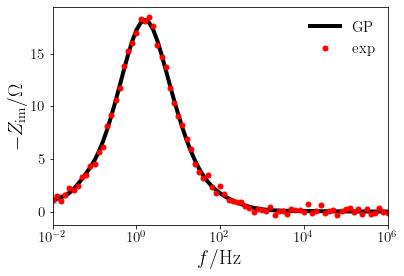

In [44]:
plt.fill_between(freq_star_vec, -mu_im_star_vec-3*sigma_im_star_vec, -mu_im_star_vec+3*sigma_im_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, -mu_im_star_vec-2*sigma_im_star_vec, -mu_im_star_vec+2*sigma_im_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, -mu_im_star_vec-sigma_im_star_vec, -mu_im_star_vec+sigma_im_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, -mu_im_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  -Z_exp.imag, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

### 5.2.1.2) Plot the regressed imaginary part

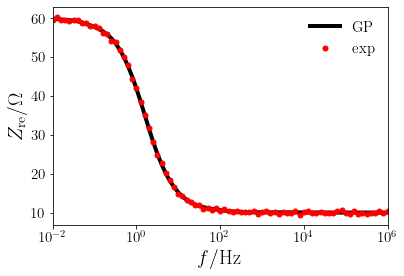

In [45]:
plt.fill_between(freq_star_vec, mu_re_star_vec-3*sigma_re_star_vec, mu_re_star_vec+3*sigma_re_star_vec,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, mu_re_star_vec-2*sigma_re_star_vec, mu_re_star_vec+2*sigma_re_star_vec,  facecolor='silver')
plt.fill_between(freq_star_vec, mu_re_star_vec-sigma_re_star_vec, mu_re_star_vec+sigma_re_star_vec,  facecolor='grey')
plt.semilogx(freq_star_vec, mu_re_star_vec, linewidth=4, color='black', label='GP')
plt.semilogx(freq_vec,  Z_exp.real, 'o', markersize=5, color='red', label='exp')
plt.xlim(1E-2, 1E6)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$Z_{\rm re}/\Omega$', fontsize=20)
plt.legend(frameon=False, fontsize = 15)
plt.show()

### 5.2.1.3) Imaginary difference plot

In [46]:
diff_im = -mu_im_star_vec+Z_exact.imag
sigma_diff_im = sigma_im_star_vec

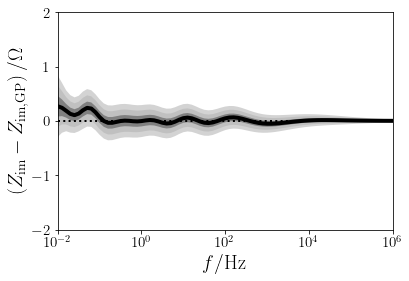

In [47]:
plt.fill_between(freq_star_vec, diff_im-3*sigma_diff_im, diff_im+3*sigma_diff_im,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, diff_im-2*sigma_diff_im, diff_im+2*sigma_diff_im,  facecolor='silver')
plt.fill_between(freq_star_vec, diff_im-sigma_diff_im, diff_im+sigma_diff_im,  facecolor='grey')
plt.semilogx(freq_star_vec, diff_im, linewidth=4, color='black', label='GP')
plt.semilogx(freq_star_vec, np.zeros_like(freq_star_vec), linewidth=2, color='black', ls = ':')
plt.xlim(1E-2, 1E6)
plt.ylim(-2, 2)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$\left(Z_{\rm im}-Z_{\rm im, GP}\right)/\Omega$', fontsize=20)
plt.show()

### 5.2.1.4) Real difference plot

In [48]:
diff_re = -mu_re_star_vec+Z_exact.real
sigma_diff_re = sigma_re_star_vec

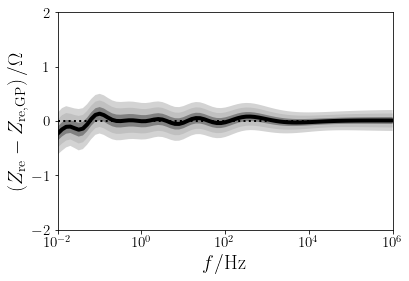

In [49]:
plt.fill_between(freq_star_vec, diff_re-3*sigma_diff_re, diff_re+3*sigma_diff_re,  facecolor='lightgrey')
plt.fill_between(freq_star_vec, diff_re-2*sigma_diff_re, diff_re+2*sigma_diff_re,  facecolor='silver')
plt.fill_between(freq_star_vec, diff_re-sigma_diff_re, diff_re+sigma_diff_re,  facecolor='grey')
plt.semilogx(freq_star_vec, diff_re, linewidth=4, color='black', label='GP')
plt.semilogx(freq_star_vec, np.zeros_like(freq_star_vec), linewidth=2, color='black', ls = ':')
plt.xlim(1E-2, 1E6)
plt.ylim(-2, 2)
plt.xscale('log')
plt.xlabel(r'$f/{\rm Hz}$', fontsize=20)
plt.ylabel(r'$\left(Z_{\rm re}-Z_{\rm re, GP}\right)/\Omega$', fontsize=20)
plt.show()

## 6) Evaluate the polarization resistance as a stochastic Gaussian variable

We recall that 

$$ 
\begin{pmatrix}
Z_{\rm re}(\omega \rightarrow 0) \\
Z_{\rm re}(\omega \rightarrow \infty) \end{pmatrix} | \; \mathbf Z = \mathbf Z_{\rm exp}
\sim \mathcal{N} \left(\bf \mu_{\rm re}(0,\infty), \mathbf \Sigma_{\rm re}(0,\infty) \right) 
$$

where 

$$
\mu_{\rm re}(0,\infty) = \begin{pmatrix}
\mu^{0}_{\rm re} \\
\mu^{\infty}_{\rm re} \end{pmatrix} = \mathbf K_{\rm re,im}(0,\infty) \mathbf K^{-1}(\bf \omega,\bf \omega) \mathbf Z_{\rm exp}
$$

$$ 
\Sigma_{\rm re}(0,\infty) = \begin{pmatrix}
\Sigma^{0}_{\rm re} & \Sigma^{0,\infty}_{\rm re} \\
\Sigma^{0,\infty}_{\rm re} & \Sigma^{\infty}_{\rm re} \end{pmatrix} = \mathbf K_{\rm re}(0,\infty) - \mathbf K_{\rm re,im}(0,\infty) \mathbf K^{-1}(\omega,\omega) \mathbf K^\top_{\rm re,im}(0,\infty) 
$$

The polarization resistance $ R_{\rm p} = Z_{\rm re}(0) - Z_{\rm re}(\infty)$ is the following Gaussian random variable

$$
R_{\rm p} \sim \mathcal{N} \left(\mu_{R_{\rm p}}, \mathbf \sigma^{2}_{R_{\rm p}} \right) 
$$

where

$$
\mu_{R_{\rm p}} = \mu^{0}_{\rm re} - \mu^{\infty}_{\rm re}
$$

$$
\sigma_{R_{\rm p}} = \sqrt{\Sigma^{0}_{\rm re} - 2\Sigma^{0,\infty}_{\rm re} + \Sigma^{\infty}_{\rm re}}
$$

In [50]:
tau_max = 10 # s

K_re0inf = np.zeros((2,2)) # equation (15a) of the manuscript
K_re0inf[0,0] = tau_max*sigma_DRT**2 + sigma_R**2 + 2*sigma_SB**2 
K_re0inf[0,1] = sigma_R**2
K_re0inf[1,0] = sigma_R**2
K_re0inf[1,1] = sigma_R**2 + sigma_SB**2 

K_reim0inf = np.zeros((2, 2*N_freqs)) # equation (15b)
for i in range(N_freqs):
    K_reim0inf[0,i] = np.arctan(tau_max*omega_vec[i])*sigma_DRT**2/omega_vec[i] + sigma_R**2 
    + 2*gpf.k_SB(0,omega_vec[i], ker_opts, 're') 
    K_reim0inf[0,i+N_freqs] = -np.log(1 + omega_vec[i]**2*tau_max**2)*sigma_DRT**2/(2*omega_vec[i]) - 2*gpf.k_SB(0,omega_vec[i], ker_opts, 're-im') 
    K_reim0inf[1,i] = sigma_R**2

# Mean of the stochastic polarization resistance, as described in (17a)
mu_Rp = np.zeros_like(omega_vec)    
alpha1 = np.linalg.solve(L, Z_exp_all) # L is the Cholesky factorisation of K_full
alpha1 = np.linalg.solve(np.transpose(L), alpha1) # alpha1 = K^(-1)*Z_exp
mu_Rp = np.dot(K_reim0inf, alpha1) # mu_Rp = K_reim(0,inf)*K^(-1)*Z_exp
stochasticRP = mu_Rp[0] - mu_Rp[1]
experimentalRP = Z_exact.real[0] - Z_exact.real[N_freqs-1]
print('stochastic RP', stochasticRP)
print('exact', experimentalRP)

# Standard deviation of the stochastic polarization resistance, as described in (17b)
alpha2 = np.linalg.solve(L, np.transpose(K_reim0inf))
alpha2 = np.linalg.solve(np.transpose(L), alpha2) 
alpha3 = np.dot(K_reim0inf, alpha2)
sigma_Rp = K_re0inf - alpha3
sigma_Rp = gpf.nearest_PD(sigma_Rp) # nearest positive definite matrix
std_Rp = np.sqrt(sigma_Rp[0,0] - 2*sigma_Rp[0,1] + sigma_Rp[1,1])
print('std_Rp', std_Rp)

stochastic RP 50.437392977258696
exact 49.720115732185604
std_Rp 0.3206591651669634
